In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [ ]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "drive/My Drive/dataset/daun"

ls: cannot access 'drive/My Drive/dataset/daun': No such file or directory


In [ ]:
from PIL import Image

sdir='drive/My Drive/dataset/dataset_tumbuhan'


filepaths=[]
labels=[]
allowed_extensions = ['.jpg', '.jpeg', '.png']

classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            extension = os.path.splitext(f)[1].lower()
            if extension in allowed_extensions:
                try:
                    img = Image.open(fpath)
                    # img = img.resize((224, 224))  # Resize the image to desired size

                    filepaths.append(fpath)
                    labels.append(klass)
                except (OSError, IOError):
                    print("Error opening image:", fpath)
            else:
                print("Unsupported file format:", fpath)                  
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths          labels
0  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
1  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
2  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
3  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
4  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
Pohon Trembesi        345
Pohon Bungur          318
Pohon Kerai Payung    317
Pohon Cassia          316
pohon Matoa           313
Pohon Beringin        298
Pohon Kenanga         285
Pohon Saga            235
Pohon Jati            224
pohon Mahoni          215
Name: labels, dtype: int64


In [ ]:
df.head()

filepaths          labels
0  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
1  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
2  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
3  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi
4  drive/My Drive/dataset/dataset_tumbuhan/Pohon ...  Pohon Trembesi

### split df into train_df, test_df and valid_df

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  2292   test_df length:  287   valid_df length:  287


### create train, test, valid  generators

In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,
                            #rotation_range=20,
    #@width_shift_range=0.2,
   # height_shift_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True)
)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  41   test steps:  7
Found 2292 validated image filenames belonging to 10 classes.
Found 287 validated image filenames belonging to 10 classes.
Found 287 validated image filenames belonging to 10 classes.
['Pohon Beringin', 'Pohon Bungur', 'Pohon Cassia', 'Pohon Jati', 'Pohon Kenanga', 'Pohon Kerai Payung', 'Pohon Saga', 'Pohon Trembesi', 'pohon Mahoni', 'pohon Matoa']


### create function to show some image examples

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

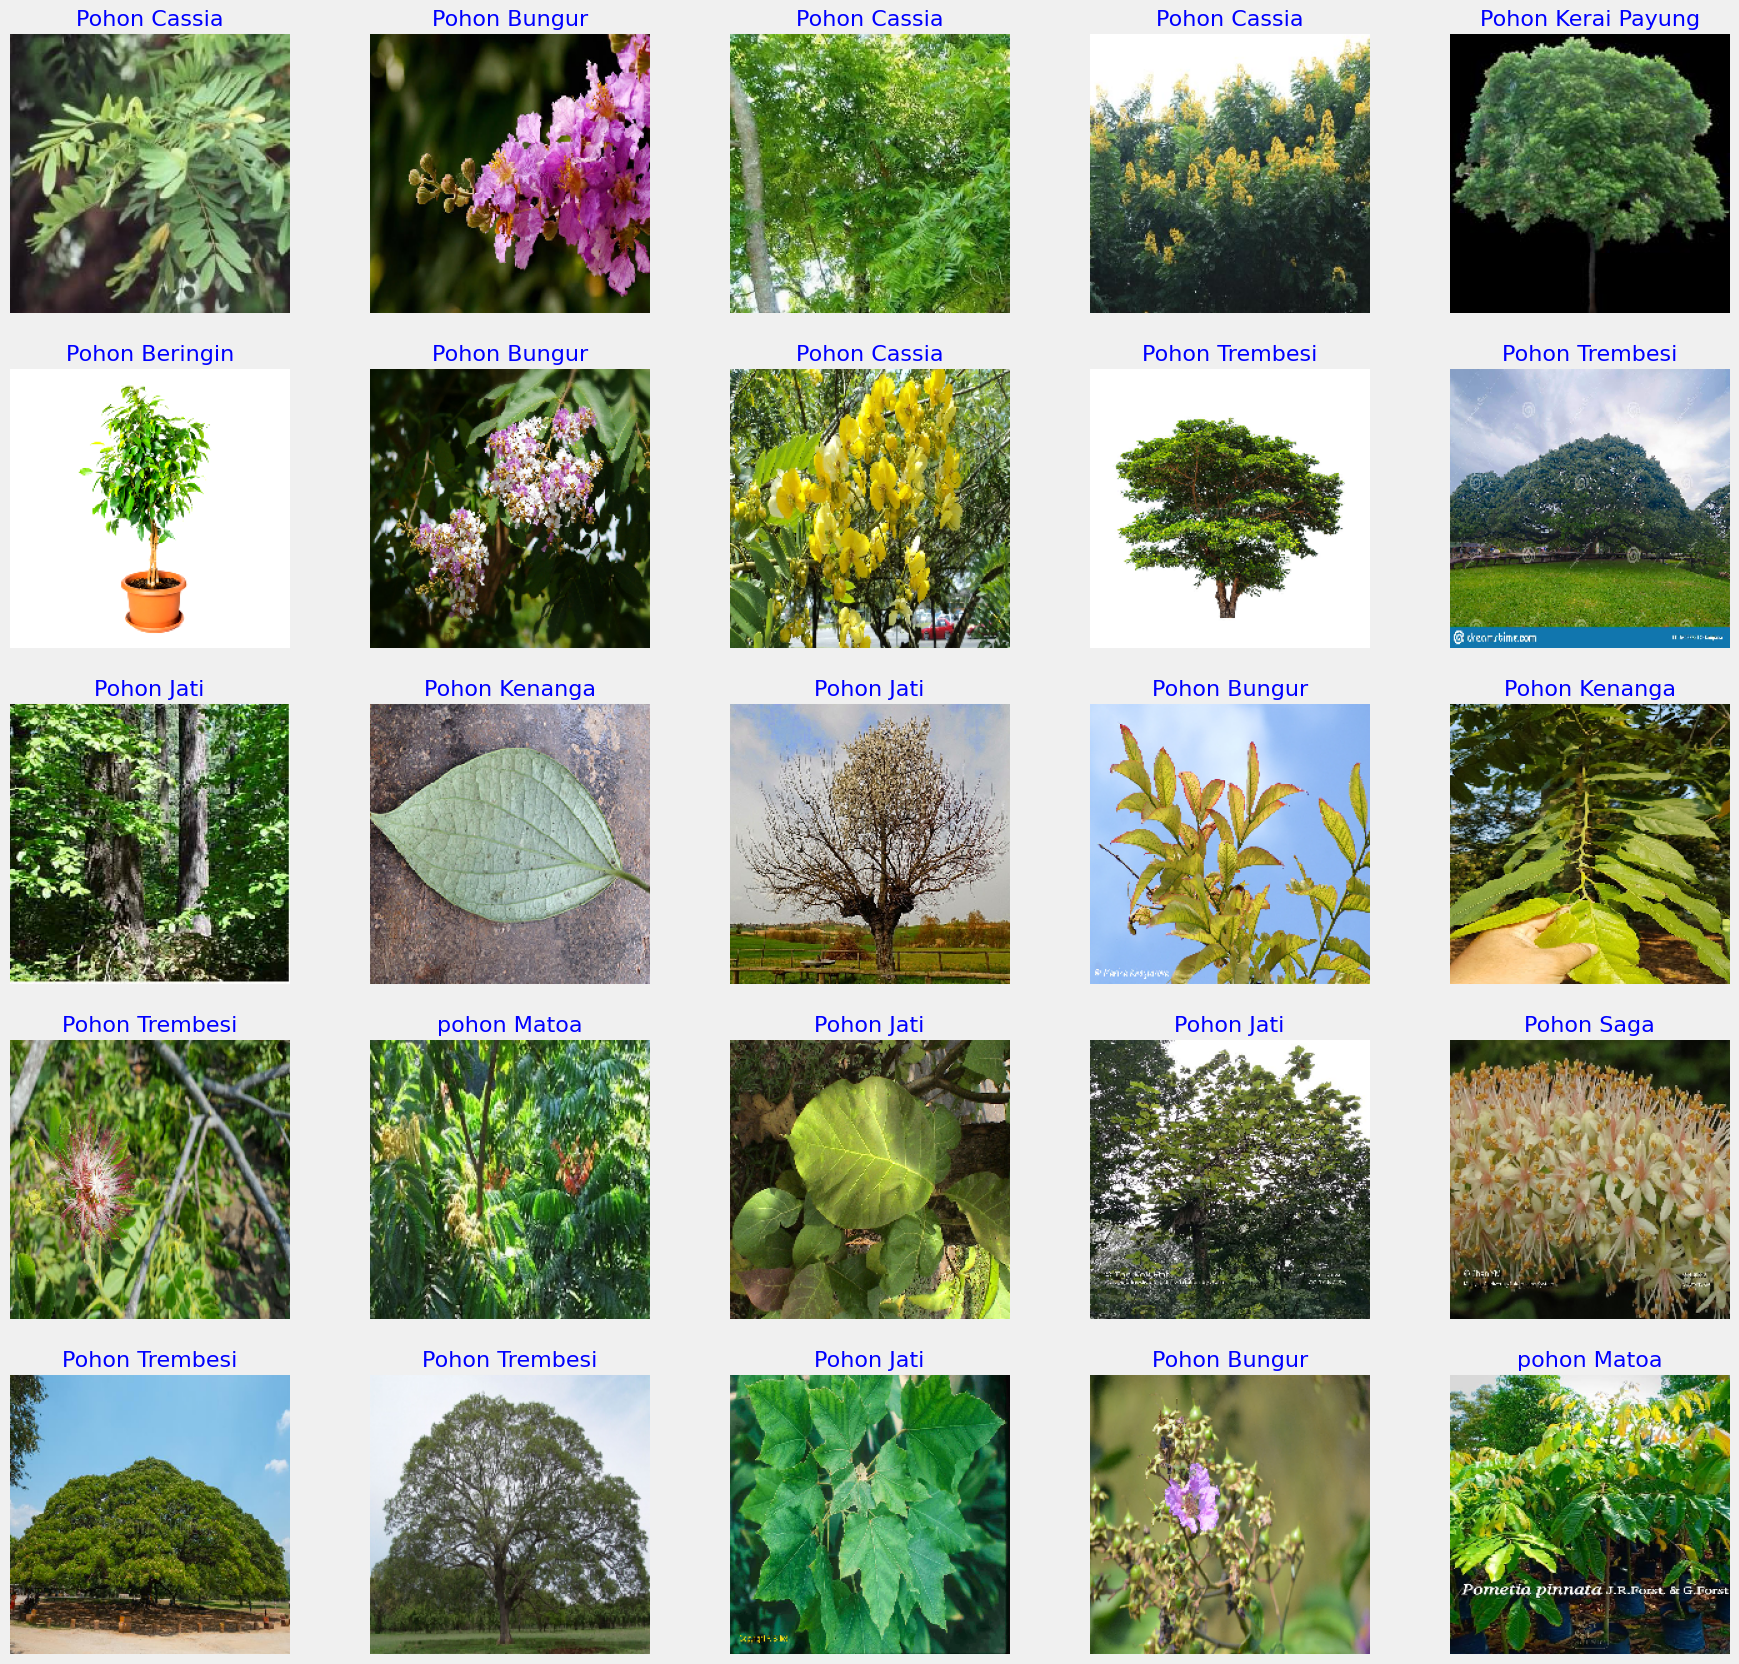

In [ ]:
show_image_samples(train_gen)

### create the model

In [ ]:
# from tf.keras.applications.vgg16 import VGG16
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
model_name='jejak'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            # tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            # tf.keras.layers.Dropout(rate=0.5),
            # tf.keras.layers.Conv2D(filters=512, padding='same', kernel_size=3, activation='relu', strides=1),
            
            tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding='same',  activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7fec30bcd600>


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 1024)        4719616   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 3, 3, 1024)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                92170     
                                                      

In [ ]:
epochs =25

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/25
36/36 [==============================] - 49s 1s/step - loss: 2.4657 - accuracy: 0.2648 - val_loss: 1.8937 - val_accuracy: 0.3659
Epoch 2/25
36/36 [==============================] - 48s 1s/step - loss: 1.6061 - accuracy: 0.4638 - val_loss: 1.6377 - val_accuracy: 0.4913
Epoch 3/25
36/36 [==============================] - 50s 1s/step - loss: 1.2609 - accuracy: 0.6047 - val_loss: 1.5757 - val_accuracy: 0.4739
Epoch 4/25
36/36 [==============================] - 48s 1s/step - loss: 1.0152 - accuracy: 0.6867 - val_loss: 1.4216 - val_accuracy: 0.5679
Epoch 5/25
36/36 [==============================] - 49s 1s/step - loss: 0.7808 - accuracy: 0.7574 - val_loss: 1.3665 - val_accuracy: 0.5749
Epoch 6/25
36/36 [==============================] - 48s 1s/step - loss: 0.6144 - accuracy: 0.8207 - val_loss: 1.2724 - val_accuracy: 0.6272
Epoch 7/25
36/36 [==============================] - 54s 2s/step - loss: 0.4863 - accuracy: 0.8652 - val_loss: 1.2190 - val_accuracy: 0.6481
Epoch 8/25
36/36 [==

### define function to print text in RGB foreground and background colors

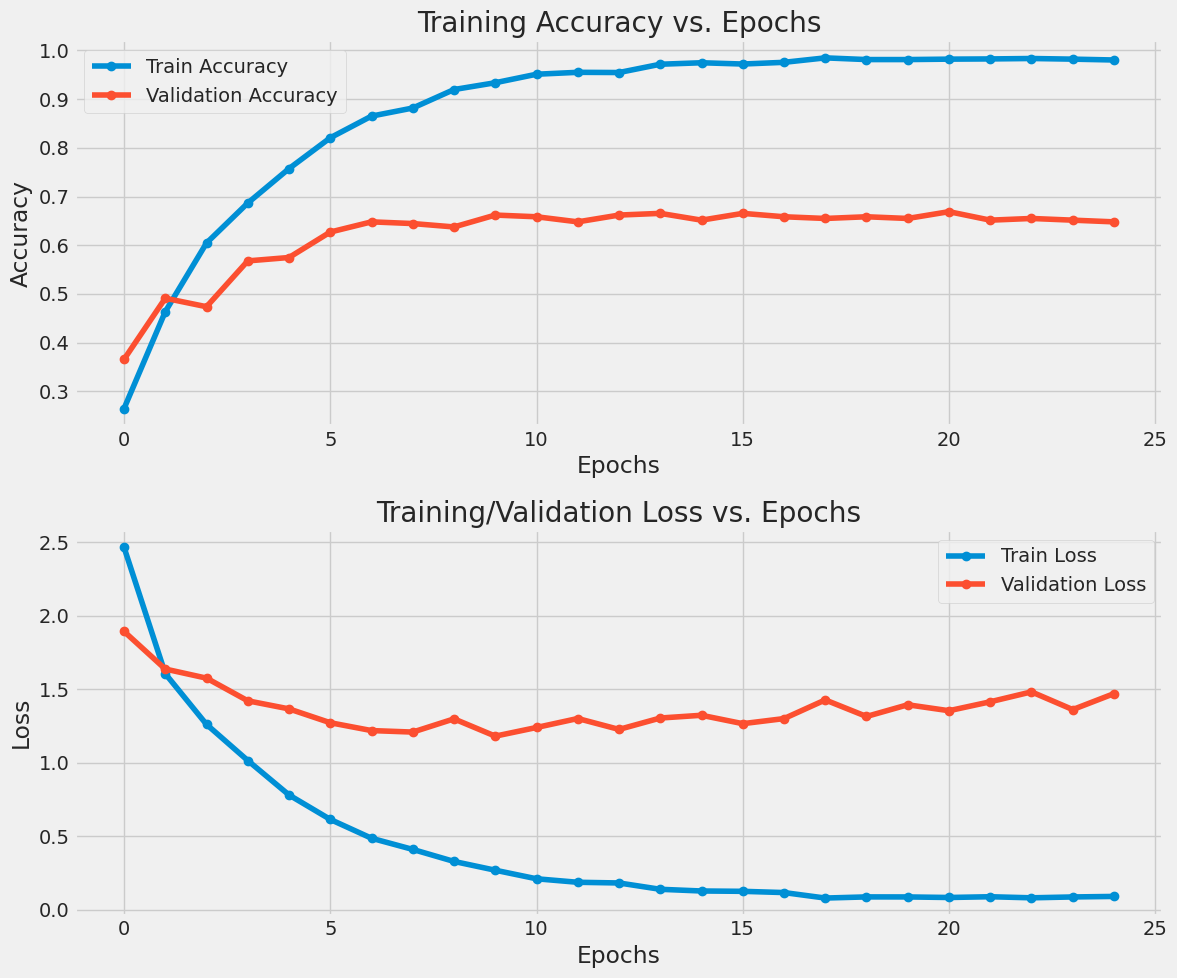

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_gen)

7/7 [==============================] - 5s 625ms/step


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, batch_size=batch_size)

7/7 [==============================] - 6s 813ms/step - loss: 1.3562 - accuracy: 0.7282


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.3561971187591553
Test Accuracy: 0.7282230257987976


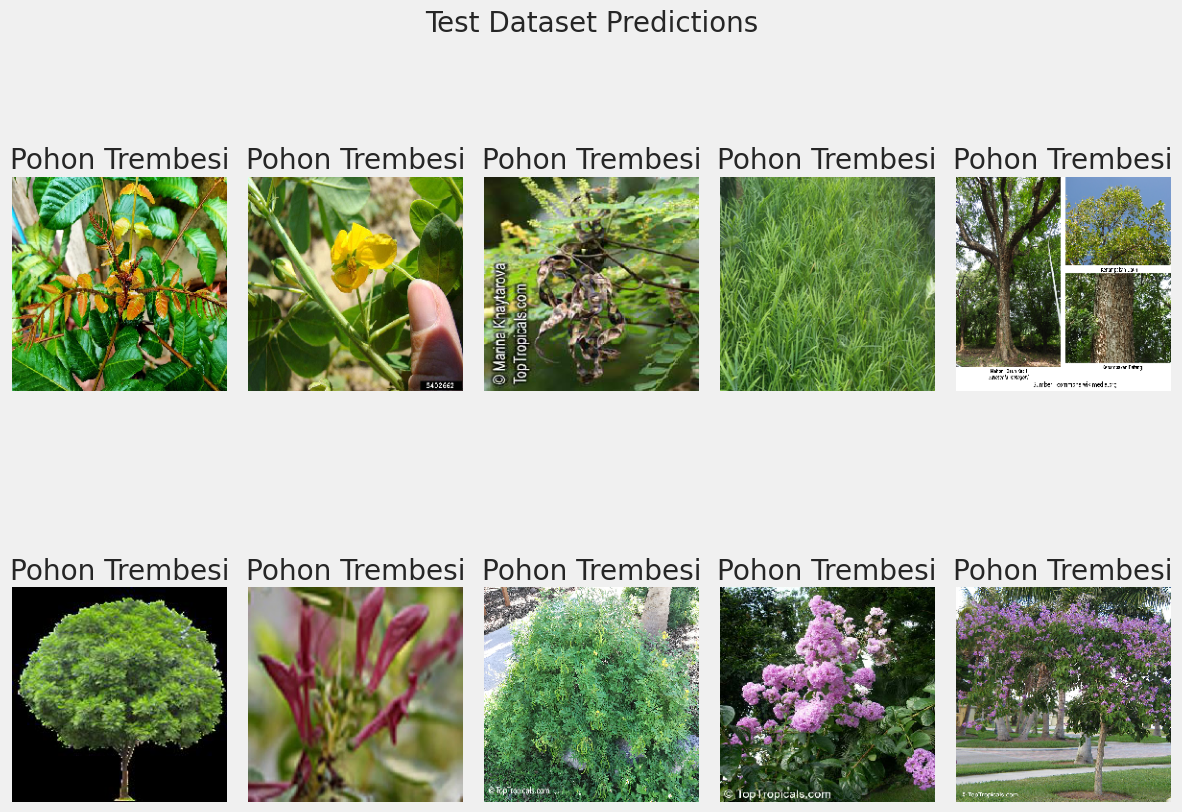

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_gen[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

## Buat Grafik metrik klasifikasinya

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

AttributeError: ignored

### define function to plot the training data

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

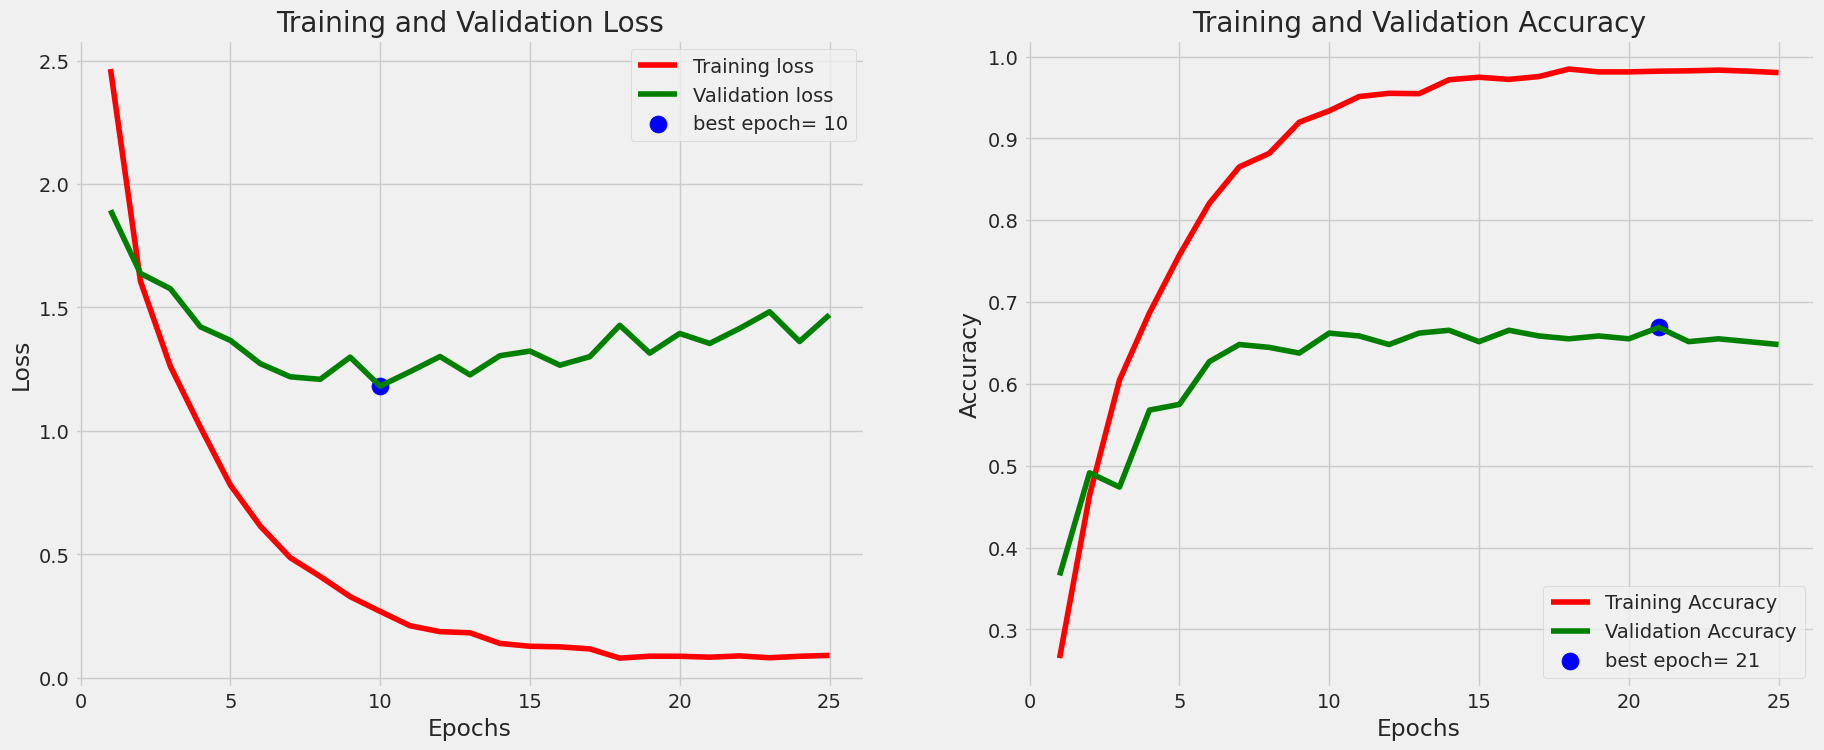

7/7 [==============================] - 5s 625ms/step - loss: 1.3562 - accuracy: 0.7282


NameError: ignored

In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='Batik Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
# model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [ ]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import save_model

# Masuk ke direktori yang diinginkan
os.chdir('/content')

# Simpan model ke file .h5
model.save('model_v2.h5')

# Mengunduh model
from google.colab import files
files.download('model_v2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>